# Практика обучения моделей 2

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fintech-dl-hse/course/blob/main/seminars/03_seminar_solved.ipynb)



[**Непрорешеный семинар**](https://github.com/m12sl/dl-hse-2021/blob/main/03-training/seminar.ipynb)


**Feedback**

* больше комментов к коду

* пояснения англицизмов

    **(не бойтесь перебивать меня, уточнять любые непонятные слова)**

* побольше времени на домашки 

    2 недели --- норм? Штрафы за просрочку дедлайнов имхо очень лояльные. Домашки -- это самое классное в курсе)

* Более подробный разбор дз хотя бы в общих чертах помогла бы




# План семинара:

**Recap**

* что такое нейросети :)
* какие лоссы для каких задач используются

**Что-то новенькое**

* Classier Trainer
* LR range test
* LR scheduling
* Warmup
* Batch Size / lr = const


**Блиц**

**Weight initialization**

* Разбор первой части будущей домашки
    * constant init
    * uniform init
    * uniform centered init
    * normal init

**Обзор второй части будущей домашки**

# Recap

Нейронная сеть -- просто формула с коэффициентами (весами)

Когда создаем сеть все веса инициализируются случайно.

-----

Наша задача найти веса получше, действуем итеративно:
* считаем частные производные (бекпроп)
* обновляем веса (делаем градиентный спуск)


У нас есть набор операций и слоев из которых можно собрать сеть и представление о предметной области:
```
табличные данные -> MLP
сигналы, тексты -> CNN (на Conv1d) или RNN, Трансформеры
картинки -> CNN (на conv2d)
```

Разные задачи:

### Делаем регрессию

* Linear(..., N) + **Mean Squared Error** ([дока PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss))

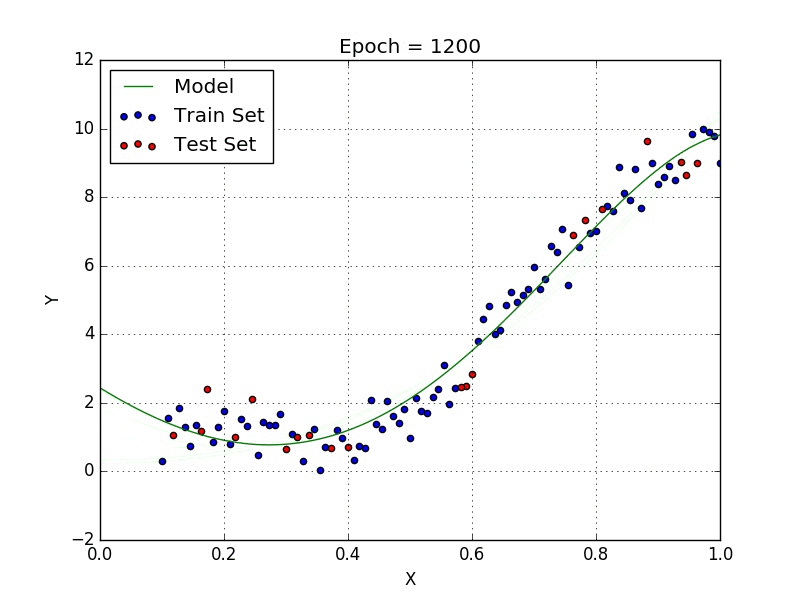

In [31]:
import torch.nn as nn
import torch

loss = nn.MSELoss()
input = torch.randn(3, 2, requires_grad=True)
target = torch.randn(3, 2)

output = loss.forward(input, target)
output

tensor(0.7521, grad_fn=<MseLossBackward0>)

tensor(1.9117, grad_fn=<MseLossBackward0>)


### Делаем классификацию:

**Cross Entropy** ([дока PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html))


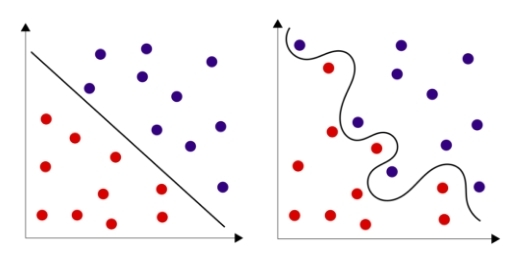

In [24]:
# Example of target with class indices

import torch.nn as nn

loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True) # [ batch_size, class_probability ]

# [ batch_size ] -- метки каждого класса, каждая метка -- это число от [0 до 5)
target = torch.empty(3, dtype=torch.long).random_(5)

output = loss(input, target)
output

tensor(2.2372, grad_fn=<NllLossBackward0>)

### Делаем теггирование:

**Binary Cross Entropy** ([дока PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html))


PS Сори, картинки не нашел, но примером может быть задача тэгорования треков: один трек может именть несколько жанров: `pop`, `rock`, `jazz`, `russian`, `1980s`...

In [25]:
sigmoid = nn.Sigmoid()
loss = nn.BCELoss()

input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)

output = loss(sigmoid(input), target)
output

tensor(0.7115, grad_fn=<BinaryCrossEntropyBackward0>)

# Метрики

TL; DR:
- тренировочные метрики записывать без сглаживания с каждого батча
- валидационные собирать за всю валидацию и рисовать одной точкой


**Особенности TB**:

- При отображении прореживает точки по global_step, если точек очень много
- Чтобы рисовать на одном графике надо писать в разные папки (завести отдельные train_ и val_writer)
- Хорошей идеей будет создание новой директории с логами для нового эксперимента (можно завязаться, например, на текущую дату+время, чтобы не было коллизий для новых запусков трейнеров)

# Обновим Trainer


In [9]:
from copy import deepcopy

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [10]:
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

from torchvision.transforms import ToTensor

from torch.optim import Adam

class FMNISTImageSet:
    def __init__(self, train=True, transform=None):
        self.data = FashionMNIST("./tmp", train=train, download=True)

        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        # сделайте одноканальную картинку [1, 28, 28] с float32
        sample, label = self.data[item]

        if self.transform is not None:
            sample = self.transform(sample)
        else:
            sample = np.array(sample, dtype=np.float32)[None:, ...] / 255


        return dict(
            sample=sample,
            label=label,
        )

fmnist_train = FMNISTImageSet(train=True, transform=ToTensor())
fmnist_val = FMNISTImageSet(train=False, transform=ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./tmp/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./tmp/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./tmp/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./tmp/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./tmp/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./tmp/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./tmp/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./tmp/FashionMNIST/raw



In [11]:
class VeryModel(nn.Module):
    def __init__(self, lr_scheduler=None, lr_scheduler_type=None):
        super().__init__()
        self.lr_scheduler = lr_scheduler
        self.lr_scheduler_type = lr_scheduler_type
        if lr_scheduler_type not in [None, 'per_batch', 'per_epoch']:
            raise ValueError("lr_scheduler_type must be one of: None, 'per_batch', 'per_epoch'. "
                             f"Not: {lr_scheduler_type}")

        self.inner = nn.Sequential(nn.Flatten(),
                                   nn.Linear(784, 100),
                                   nn.ReLU(),
                                   nn.Linear(100, 10))

    def forward(self, x):
        return self.inner(x)

    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        x = batch['sample'] / 255.0
        y = batch['label']
        logits = self.inner(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)

        return loss, metrics

    def post_train_batch(self):
        # called after every train batch
        if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_batch':
            self.lr_scheduler.step()

    def post_val_batch(self):
        pass

    def post_train_stage(self):
        pass

    def post_val_stage(self, val_loss):
        # called after every end of val stage (equals to epoch end)
        if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_epoch':
            self.lr_scheduler.step(val_loss)


class Trainer:
    def __init__(self, model: nn.Module,
                 optimizer,
                 train_dataset: Dataset,
                 val_dataset: Dataset,
                 tboard_log_dir: str = './tboard_logs/',
                 batch_size: int = 128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.log_writer = SummaryWriter(log_dir=tboard_log_dir)

        # сохраняем состояние оптимизатора и модели
        self.cache = self.cache_states()

    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=True, pin_memory=True, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size)
        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                model.post_train_batch()
                for k, v in details.items():
                    self.log_writer.add_scalar(k, v, global_step=self.global_step)
                self.global_step += 1

            with torch.no_grad():
                model.eval()
                val_losses = []
                for batch in tqdm(val_loader):
                    batch = {k: v.to(self.device) for k, v in batch.items()}
                    loss, details = model.compute_all(batch)
                    val_losses.append(loss.item())

                val_loss = np.mean(val_losses)
                model.post_val_stage(val_loss)

                if val_loss < best_loss:
                    self.save_checkpoint("./best_checkpoint.pth")
                    best_loss = val_loss

    def find_lr(self, min_lr: float = 1e-6,
                max_lr: float = 1e-1,
                num_lrs: int = 20,
                smooth_beta: float = 0.8) -> dict:
        lrs = np.geomspace(start=min_lr, stop=max_lr, num=num_lrs)
        logs = {'lr': [], 'loss': [], 'avg_loss': []}
        avg_loss = None
        model, optimizer = self.model, self.optimizer
        train_loader = DataLoader(self.train_dataset, shuffle=True, batch_size=self.batch_size)

        model.train()
        for lr, batch in tqdm(zip(lrs, train_loader), desc='finding LR', total=num_lrs):
            # apply new lr
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr

            # train step
            batch = {k: v.to(self.device) for k, v in batch.items()}
            loss, details = model.compute_all(batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate smoothed loss
            if avg_loss is None:
                avg_loss = loss
            else:
                avg_loss = smooth_beta * avg_loss + (1 - smooth_beta) * loss

            # store values into logs
            logs['lr'].append(lr)
            logs['avg_loss'].append(avg_loss.item())
            logs['loss'].append(loss.item())

        logs.update({key: np.array(val) for key, val in logs.items()})
        self.rollback_states()

        return logs

    def cache_states(self):
        cache_dict = {'model_state': deepcopy(self.model.state_dict()),
                      'optimizer_state': deepcopy(self.optimizer.state_dict())}

        return cache_dict

    def rollback_states(self):
        self.model.load_state_dict(self.cache['model_state'])
        self.optimizer.load_state_dict(self.cache['optimizer_state'])


In [32]:
model = VeryModel()
optimizer = Adam(model.parameters(), lr=3e-4)

trainer = Trainer(model, optimizer, fmnist_train, fmnist_val)

In [33]:
find_learning_rate_logs = trainer.find_lr(num_lrs=300)
find_learning_rate_logs

finding LR:   0%|          | 0/300 [00:00<?, ?it/s]

{'avg_loss': array([2.30317569, 2.3047092 , 2.30410624, 2.30517268, 2.30592895,
        2.30633593, 2.30615234, 2.30544305, 2.30453348, 2.30464792,
        2.30207705, 2.30318213, 2.30209255, 2.30366516, 2.30356169,
        2.30500984, 2.30528879, 2.3053875 , 2.30459332, 2.30330777,
        2.30345798, 2.30306101, 2.30254126, 2.30339599, 2.30158925,
        2.30389929, 2.30341029, 2.30440044, 2.30438828, 2.30406141,
        2.3032732 , 2.30359077, 2.30389428, 2.30437827, 2.30529356,
        2.3042686 , 2.30234432, 2.30181289, 2.30321479, 2.3020885 ,
        2.30275106, 2.30364728, 2.30476832, 2.30472612, 2.30589461,
        2.30587959, 2.30461454, 2.30290127, 2.30380654, 2.30388784,
        2.30485344, 2.30338264, 2.30382848, 2.3030436 , 2.30209422,
        2.30272818, 2.30492687, 2.30349278, 2.30260301, 2.30223393,
        2.30152941, 2.30154133, 2.30299997, 2.30284309, 2.30307007,
        2.3026998 , 2.3018899 , 2.30194068, 2.3001864 , 2.29906344,
        2.29956698, 2.29804993, 2.30

# Find lr

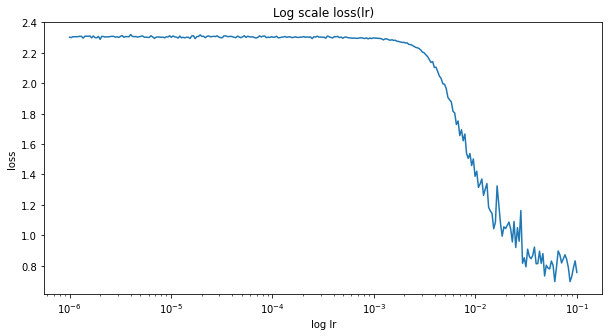

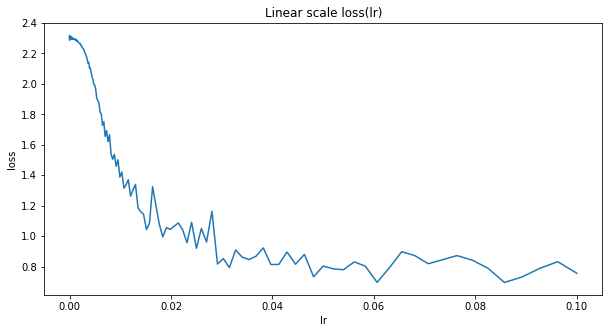

In [14]:
plt.plot(find_learning_rate_logs['lr'], find_learning_rate_logs['loss'])
plt.xscale('log')
plt.gcf().set_size_inches((10, 5))
plt.xlabel("log lr")
plt.ylabel("loss")
plt.title("Log scale loss(lr)")

plt.figure(2)
plt.plot(find_learning_rate_logs['lr'], find_learning_rate_logs['loss'])
plt.xlabel("lr")
plt.ylabel("loss")
plt.title("Linear scale loss(lr)")
plt.gcf().set_size_inches((10, 5))

# Выбор оптимального LR


Для выбора оптимального LR удобно использовать т.н. Learning Rate Range Test, часто процедуру называют просто find_lr. Под капотом проход по тренировочной эпохе с lr, изменяемым на каждом батче по формуле:

$$
\mathrm{it} = \frac{\mathrm{step}}{\mathrm{total steps}}\\
\mathrm{lr} = \exp\left\{ 
    (1 - t ) \log a + t \log b
\right\}
$$

Чтобы поменять LR для всех оптимизируемых параметров, можно пройтись по ним циклом:

```
for param_group in optimizer.param_groups:
    param_group['lr'] = lr
```


<img src="https://www.jeremyjordan.me/content/images/2018/02/lr_finder.png"/>

_картинка из бложика [Jeremy Jordan](https://www.jeremyjordan.me/nn-learning-rate/)_


Идея приема простая: пока LR меньше некоторого порога на каждом шаге градиентного спуска веса просто не меняются (в частности из-за особенностей операций с плавающей точкой).
При очень большом LR мы шагаем слишком далеко и уходим от точки экстремума. 

Оптимальный LR лежит где-то между ними. Экспоненциальная формула изменения LR позволяет с должным качеством найти хорошую точку.



Если интересно: [статья , в которой эту технику предложили и активно использовали](https://arxiv.org/pdf/1506.01186.pdf).


**Some math notes**

У типов данных с плавающей точкой есть арифметические особенности:

**fp32**
$$
x + \delta == x,\,\mathrm{если}\; \delta < 5.96 \cdot 10^{-8} x
$$

К слову, это еще одна причина присматривать за величинами активаций, нормировать данные и таргет в случае регрессии. Можно было бы перейти на float64, но (вычислительно и по памяти) дешевле быть аккуратными на float32.



<img src="https://blogs.nvidia.com/wp-content/uploads/2020/05/tf32-Mantissa-chart-hi-res-FINAL-400x255.png.webp"/>

_картинка из статьи [NVIDIA](https://blogs.nvidia.com/blog/2020/05/14/tensorfloat-32-precision-format/)_

## [отступление] Задача на сложение чисел с плавующей точкой

Есть массив чисел с плавующей точкой. Нужно найти сумму этих чисел.


In [35]:
import numpy as np

float_array = np.exp(np.linspace(-15, 10, 100)).astype(np.float32)
float_array[:3], float_array[-3:]

(array([3.0590232e-07, 3.9377949e-07, 5.0690130e-07], dtype=float32),
 array([13292.424, 17110.965, 22026.465], dtype=float32))

In [37]:
print("{:.8f} {:.8f}".format(float_array[0], float_array[-1]))

assert float_array[0] + float_array[-1] == float_array[-1]

0.00000031 22026.46484375


In [40]:
float_array[0] + float_array[1], float_array[0]

(6.996818e-07, 3.0590232e-07)

In [41]:

from tqdm.auto import tqdm
import bisect

float_array = np.array([1e-10] * 10000 + [ 10 ] * 100 , dtype=np.float32)

# складываем от большего к меньшему
sum = 0
for elem in reversed(float_array):
    sum += elem

print("sum", sum)


# складываем от меньшего к большему
sum_sorted = 0
for elem in float_array:
    sum_sorted += elem

print("sum_sorted", sum_sorted)


# поддерживаем сортированость массива
# sum_keep_sorted = 0
# sorted_floats = float_array.tolist()
# for _ in tqdm(range(len(sorted_floats) - 1)):
#     sorted_floats = sorted(sorted_floats)
#
#     sum_least_elements = sorted_floats.pop(0) + sorted_floats.pop(0)
#     sorted_floats.insert(0, sum_least_elements)


# поддерживаем сортированость массива, оптимальный вариант
sum_keep_sorted_optim = 0
sorted_floats_optim = float_array.tolist()
for _ in tqdm(range(len(sorted_floats_optim) - 1)):
    # более оптимальный вариант
    sum_least_elements = sorted_floats_optim.pop(0) + sorted_floats_optim.pop(0)
    bisect.insort_left(sorted_floats_optim, sum_least_elements)
    if len(sorted_floats_optim) == 1:
        sum_keep_sorted_optim = sorted_floats_optim[0]

print("sum_keep_sorted_optim", sorted_floats_optim[0])

# для того, чтобы заметить разницу между sum_keep_sorted и sum_sorted надо 5.96 e8 элементов в массиве -- это массив, который будет весить порядка гигабайта и даже для более оптимального  варианта может долго вычисляться

sum 1000.0000010004442
sum_sorted 1000.000001


  0%|          | 0/10099 [00:00<?, ?it/s]

sum_keep_sorted_optim 1000.000001


# LR Scheduler

Два типа расписаний:

- по эпохам ([StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html), [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html), ...) 
    ```
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    for epoch in range(epochs):
        train(...)
        validate(...)
        scheduler.step()
    ```


- по батчам ([Cyclic](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CyclicLR.html), [1cycle](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html#torch.optim.lr_scheduler.OneCycleLR), ...)
    ```
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)
    for epoch in range(epochs):
        # train(...)
        for batch in data_loader:
            train_batch(...)
            scheduler.step()
        # validate(...)
    ```

In [17]:
def show_scheduler(scheduler, label=None):
    lr_history = []

    if label is None:
        label = str(scheduler)

    for i in range(100):
        lr_history.append(scheduler.get_last_lr()[0])
        scheduler.step()

    plt.plot(lr_history, label=label)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Text(0.5, 1.0, 'StepLR')

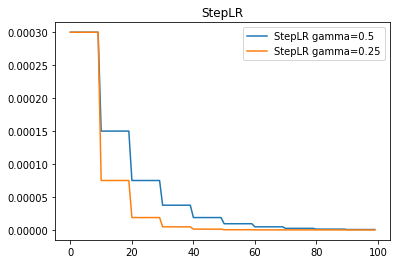

In [42]:
optimizer = Adam(model.parameters(), lr=3e-4)
show_scheduler( torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5), label="StepLR gamma=0.5" )

optimizer = Adam(model.parameters(), lr=3e-4)
show_scheduler( torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.25), label="StepLR gamma=0.25" )

plt.legend()

plt.title("StepLR")

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Text(0.5, 1.0, 'CyclicLR')

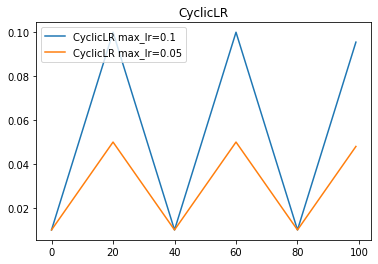

In [19]:
optimizer = Adam(model.parameters(), lr=3e-4)
show_scheduler( torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1, step_size_up=20, cycle_momentum=False), label="CyclicLR max_lr=0.1" )

optimizer = Adam(model.parameters(), lr=3e-4)
show_scheduler( torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.05, step_size_up=20, cycle_momentum=False), label="CyclicLR max_lr=0.05" )

plt.legend()

plt.title("CyclicLR")

**Вопрос:** в каких случаях может быть полезен `CyclicLR`? Зачем повышать `lr`?

#### Обучим модельку с шедулером

In [43]:
model = VeryModel(lr_scheduler=very_model_scheduler, lr_scheduler_type='per_batch')
optimizer = Adam(model.parameters(), lr=3e-4)
very_model_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.005, step_size_up=300, cycle_momentum=False)


trainer = Trainer(model, optimizer, fmnist_train, fmnist_val)
trainer.train(3)


  0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

# WarmUp

**Проблема:** очень большие сетки может сильно разнести, если сразу начать их оптимизировать на больших батчах


Чтобы сеть не расходилась сразу, можно постепенно увеличивать lr --- тогда оптимизаторы постепенно накопят статистики по разным группам параметров

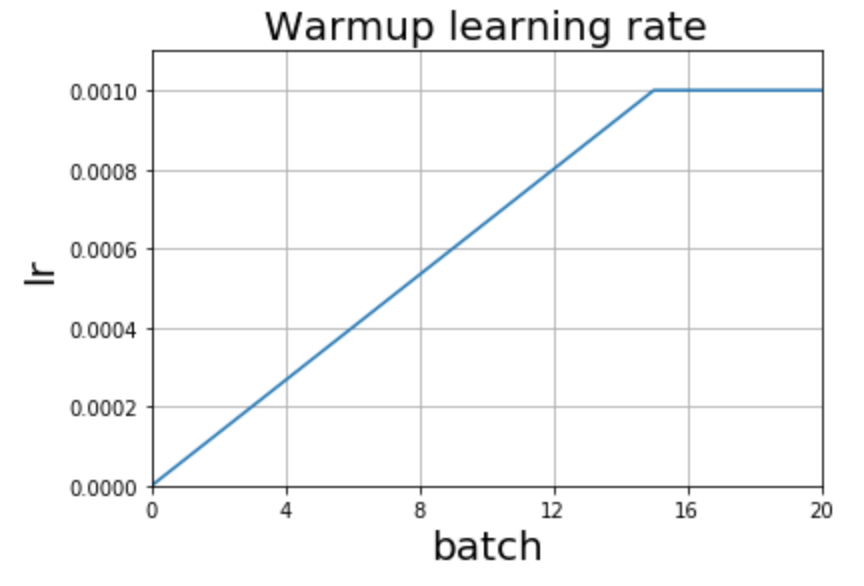


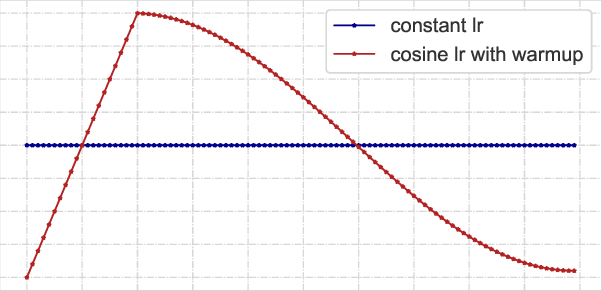

# batch_size / lr ~= const *

Для какой из линий больше `batch_size` на картинке ниже?

(*) Дисклаймер: обычно верно для конкретной задачи, для конкретной модели. Если меняется что-то одно, то это соотношение может меняться

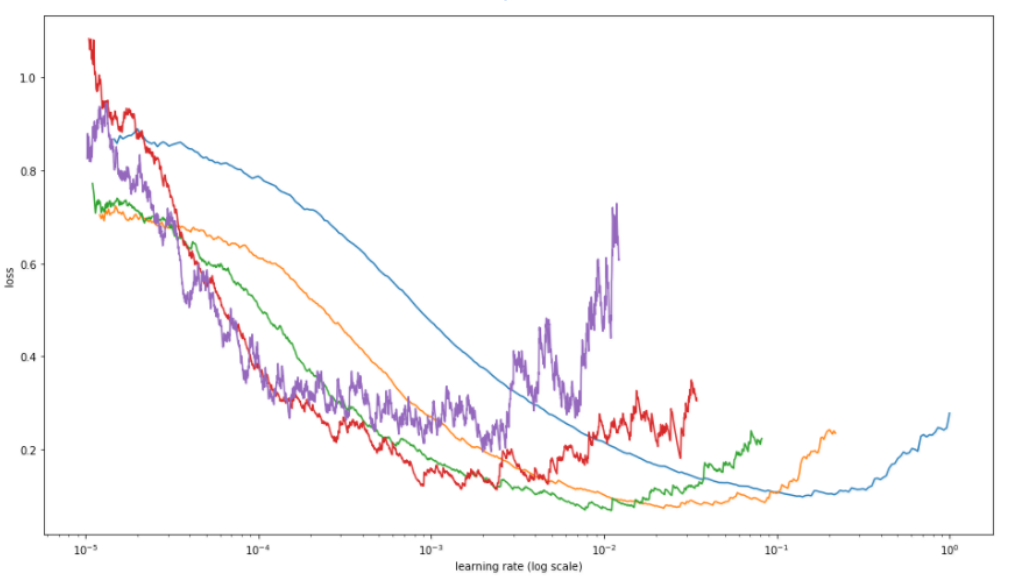

# Блиц


### Зачем нужен `transform=` в классе датасета? Когда его нужно применять?

<!---
    В этот параметр передается функция для предобработки изображения. Эта функция обычно преобразует PIL Image объект (если вы прочитали изображение с помощью cv2) или numpy.array в тензор, нормализует значения пикселей (делит на 255). Самый простой вариант трансформа --- это [ToTensor](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor)


    Еще с помощью этого метода можно сделать аугментацию изображения: 

    * [Resize](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Resize) --- отмасштабировать изображение
    * [RandomHorizontalFlip](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomHorizontalFlip) --- перевернуть
    * [RandomRotation](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomRotation) --- повернуть

    С помощью аугментаций мы расширяем обучающую выборку при этом не прибегая к ручному сбору данных. Это позволяет обучить более стабильную сеть, часто повысить качество сети.

--->

### Зачем нужен lr warmup?

<!---

Используется для обучения больших сетей для того, чтобы 

-->

### Зачем нужен lr scheduling?

<!---

Чтобы получить лучшее качество модели или увеличить скорость обучения. Например, в начале обучения мы хотим побыстрее прийти к области с точкой оптимума. Но после того как мы к ней приблизились мы можем захотеть уменьшить lr для того, чтобы более точно подобрать значения параметров

--->



### Почему мы рассмотрели задачу об особенностях хранения чисел с плавующей точкой?

<!---

При маленьких значениях lr веса сети не будут обновляться из-за того, что операции с числаим с плавующей точкой имеют ограниченную точность

-->

### Как нужно изменить lr, если мы увеличили batch_size в 3 раза?

<!---

Для того, чтобы сохранить такую же скорость оптимизации LR нужно тоже увеличить в 3 раза.*

* Для определенной задачи, батч сайза

-->


### Как выбрать хорошие начальные значения для lr?

<!---

С помощью LR Finder'а

Строим зависимость Loss(learning_rate) и ищем точку перегиба. Диапозон неплохих lr будет начинаться в точке перегиба (возможно чуть левее), когда сеть начинает учиться, а заканчиваться до момента, когда лосс начинает шуметь, флуктуировать, колбасить

--->


# Обзоры/разборы домашек